In [1]:
import numpy as np
import pandas as pd
import pandas_profiling 

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from pylab import *

# 1. Introduction

Context
There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

Content
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

https://www.kaggle.com/ntnu-testimon/paysim1

In [2]:
dataset = pd.read_csv("PS_20174392719_1491204439457_log.csv")
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [3]:
dataset.isnull().mean() * 100

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

# 2. EDA

In [4]:
dataset.shape

(6362620, 11)

## Step

In [5]:
dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [6]:
fraud_distribution = dataset['isFraud'].value_counts()
fraud_percentage = fraud_distribution[1] / (fraud_distribution[1] + fraud_distribution[0]) * 100
print('The dataset contains ' + str(fraud_percentage) + ' % of fraud cases.')

The dataset contains 0.12908204481801522 % of fraud cases.


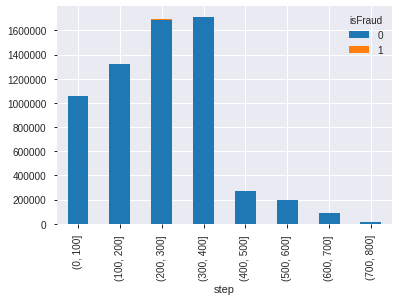

In [7]:
step_bins = [0, 100, 200, 300, 400, 500, 600, 700, 800]
step_groups = dataset.groupby([pd.cut(dataset.step, step_bins), 'isFraud'])
step_groups = step_groups.size().unstack()
step_groups.plot(kind = 'bar', stacked = True)

In [8]:
step_groups['%'] = step_groups[1] / (step_groups[0] + step_groups[1]) * 100
step_groups

isFraud,0,1,%
step,,,
"(0, 100]",1058326,1190,0.112315
"(100, 200]",1321602,1064,0.080444
"(200, 300]",1690321,1147,0.067811
"(300, 400]",1712304,1076,0.062800
"(400, 500]",273693,1084,0.394502
"(500, 600]",196188,1052,0.533360
"(600, 700]",91042,1110,1.204532
"(700, 800]",10931,490,4.290342


## Type

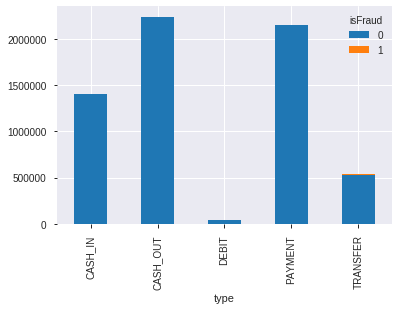

In [9]:
fraud_per_type = dataset.groupby(['type', 'isFraud'])['type'].count().unstack('isFraud')
fraud_per_type.plot(kind='bar', stacked=True)

In [10]:
fraud_per_type['%'] = (fraud_per_type[1] / (fraud_per_type[0] + fraud_per_type[1]) ) * 100
fraud_per_type

isFraud,0,1,%
type,,,
CASH_IN,1399284.0,NaN,NaN
CASH_OUT,2233384.0,4116.0,0.183955
DEBIT,41432.0,NaN,NaN
PAYMENT,2151495.0,NaN,NaN
TRANSFER,528812.0,4097.0,0.768799


We notice that there are no cases of frauds in the types of Debit, Payment and Cash_in. The fraud cases are equally distributed between Cash_out and Transfer (in absolute terms). On the other hand, in relative terms, Transfer holds more fraud cases.

## Amount

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4be71ee690>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4be7262a10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4be72629d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4be71f5b90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4be71eec90>],
 'means': []}

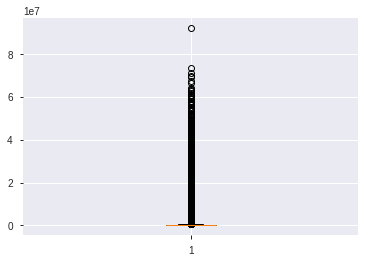

In [11]:
plt.boxplot(dataset['amount'])

In [12]:
df_fraud = dataset[dataset['isFraud'] == 1]
df_nofraud = dataset[dataset['isFraud'] == 0]

In [13]:
fraud_mean = df_fraud['amount'].mean()
fraud_median = df_fraud['amount'].median()

nofraud_mean = df_nofraud['amount'].mean()
nofraud_median = df_nofraud['amount'].median()

print('For fraud cases the mean transaction amount is ' + str(fraud_mean) + ' and the median ' + str(fraud_median))
print('For non-fraud cases the mean transaction amount is ' + str(nofraud_mean) + ' and the median ' + str(nofraud_median))

For fraud cases the mean transaction amount is 1467967.299140387 and the median 441423.44
For non-fraud cases the mean transaction amount is 178197.04172740763 and the median 74684.72


In both fraud and non fraud cases, there is a large difference between the mean and median. We could already deduce said difference from the abundance of outliers in the boxplot, pulling the mean upwards significantly. 

For normal, non-fraud cases, the median amount is 74,684 whilst the mean is almost three times larger 178,197. For fraud cases, both numbers are much bigger. The median is 441,423 and the mean 1,467,967. We observe that the proportion mean-median is similar both the amounts for fraud cases are much higher than those of non-fraud operations.

## nameOrigin

In [14]:
df_fraud['nameOrig'].value_counts()

C1434246047    1
C213567087     1
C1844195426    1
C258594657     1
C1323299934    1
              ..
C2021456831    1
C193723315     1
C517450408     1
C1584512618    1
C127098115     1
Name: nameOrig, Length: 8213, dtype: int64

We notice that there are 8213 different Origin names. As there are 8213 fraud cases, we conclude that each fraud case originates from a unique account.

In [15]:
df_nofraud['nameOrig'].value_counts()

C1832548028    3
C1677795071    3
C1999539787    3
C724452879     3
C1462946854    3
              ..
C934794137     1
C1359915814    1
C1710358182    1
C344392619     1
C1094210010    1
Name: nameOrig, Length: 6345122, dtype: int64

## Old balance origin

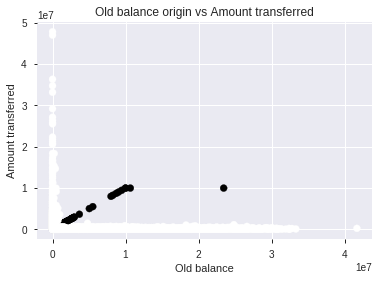

In [16]:
sample = dataset.sample(n = 100000)
plt.scatter(sample['oldbalanceOrg'], sample['amount'], c=sample['isFraud'])
plt.title("Old balance origin vs Amount transferred")
plt.xlabel("Old balance")
plt.ylabel("Amount transferred")
plt.show()

We notice two very different distributions, let us take a closer look

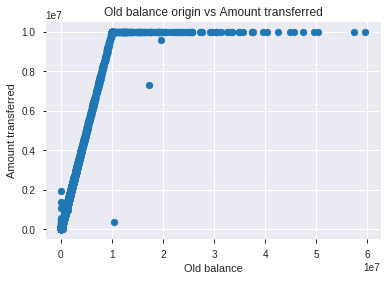

In [17]:
plt.scatter(df_fraud['oldbalanceOrg'], df_fraud['amount'])
plt.title("Old balance origin vs Amount transferred")
plt.xlabel("Old balance")
plt.ylabel("Amount transferred")
plt.show()

In [18]:
def de_mean(x):
    xmean = mean(x)
    return [xi - xmean for xi in x]

def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n-1)

def correlation(x, y):
    stddevx = x.std()
    stddevy = y.std()
    return covariance(x,y) / stddevx / stddevy  

In [19]:
correlation(df_fraud['oldbalanceOrg'], df_fraud['amount'])

0.8588592206367874

We observe a very clear - almost perfect - correlation between the amount transferred and the original amount on the account up until 1,000,000 of amount. We imagine that in a lot of cases when fraud is happening, the criminals transfer all of the money in one time to another account. Furthermore, we assume that the max transferable amount is 1,000,000.

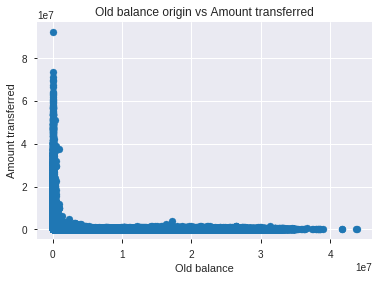

In [20]:
plt.scatter(df_nofraud['oldbalanceOrg'], df_nofraud['amount'])
plt.title("Old balance origin vs Amount transferred")
plt.xlabel("Old balance")
plt.ylabel("Amount transferred")
plt.show()

## newbalanceOrig

We notice two very different distributions, let us take a closer look

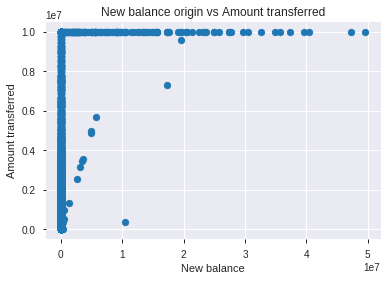

In [21]:
plt.scatter(df_fraud['newbalanceOrig'], df_fraud['amount'])
plt.title("New balance origin vs Amount transferred")
plt.xlabel("New balance")
plt.ylabel("Amount transferred")
plt.show()

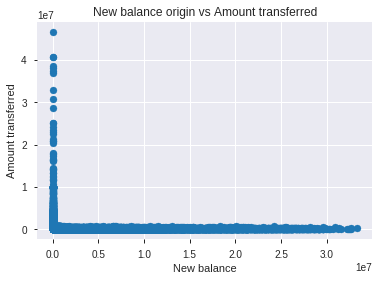

In [22]:
sample = df_nofraud.sample(n = 100000)
plt.scatter(sample['newbalanceOrig'], sample['amount'])
plt.title("New balance origin vs Amount transferred")
plt.xlabel("New balance")
plt.ylabel("Amount transferred")
plt.show()

## nameDest

In [23]:
df_fraud['nameDest'].value_counts()

C1980653895    2
C185805228     2
C1650668671    2
C475338087     2
C668046170     2
              ..
C778459251     1
C730500505     1
C278143037     1
C971747448     1
C1356666800    1
Name: nameDest, Length: 8169, dtype: int64

From the 8213 fraudulous transactions 44, were destined to an a destiny account that was already used in a previous fraudulous transaction. The majority however goes to a new account.

In [24]:
df_nofraud['nameDest'].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C1590550415    101
              ... 
M369199016       1
M1662321307      1
M506593446       1
M401318282       1
M1765808512      1
Name: nameDest, Length: 2719685, dtype: int64

In [25]:
df_nofraud.shape

(6354407, 11)

In non fraudulous transactions it is much more common that destination accounts are used more than once.

In [26]:
dest_freq = dataset.groupby('nameDest')['nameDest'].count()
dest_fraud_freq = dataset.groupby('nameDest')['isFraud'].sum()

dest_freq = dest_freq.to_frame()
dest_fraud_freq = dest_fraud_freq.to_frame()

dest_freq.columns = ['destfreq']
dest_fraud_freq.columns = ['fraudfreq']

dest_freq = dest_freq.reset_index()
dest_fraud_freq = dest_fraud_freq.reset_index()

dest_freq = pd.merge(dest_freq, dest_fraud_freq, on = 'nameDest')

In [27]:
dest_fraud_selection = dest_freq[dest_freq['fraudfreq'] > 0]
dest_fraud_selection = dest_fraud_selection[dest_fraud_selection['destfreq'] > 1]
dest_fraud_selection

,nameDest,destfreq,fraudfreq
11,C1000039615,3,1
264,C1000855680,2,1
389,C1001258143,9,1
583,C1002031672,36,1
635,C1002183297,7,1
...,...,...,...
571328,C997789760,3,1
571398,C998024073,8,1
571481,C998349190,6,1
571807,C999409522,8,1


From the 8213 fraudulous operations, 5496 involve a transfer to an account that received other transfers in the past.

### Merchant check

In [28]:
dest_merchants = dataset[dataset['nameDest'].str.contains("M")]
dest_merchants.shape

(2151495, 11)

In [29]:
dest_merchants['isFraud'].value_counts()

0    2151495
Name: isFraud, dtype: int64

There is no account information available for accounts of merchants. Nonetheless, we see that no fraudulous transaction has a 'merchant account' as destination.

## oldbalanceDest

In [30]:
fraud_mean = df_fraud['oldbalanceDest'].mean()
fraud_median = df_fraud['oldbalanceDest'].median()

nofraud_mean = df_nofraud['oldbalanceDest'].mean()
nofraud_median = df_nofraud['oldbalanceDest'].median()

print('For fraud cases the mean old balance of the destination account is ' + str(fraud_mean) + ' and the median ' + str(fraud_median))
print('For non-fraud cases the mean old balance of the destination account is ' + str(nofraud_mean) + ' and the median ' + str(nofraud_median))

For fraud cases the mean old balance of the destination account is 544249.6190746377 and the median 0.0
For non-fraud cases the mean old balance of the destination account is 1101420.8745693793 and the median 133311.8


In [31]:
len(df_fraud[(df_fraud['oldbalanceDest'] == 0)]) / len(df_fraud['oldbalanceDest']) * 100

65.15280652623889

In [32]:
len(df_nofraud[(df_nofraud['oldbalanceDest'] == 0)]) / len(df_nofraud['oldbalanceDest']) * 100

42.47504133745289

65% of the fraudulent transactations are destined to an empty account, compared to a 42% of normal operations.

## newbalanceDest

In [33]:
dest_no_merchants = dataset[~dataset['nameDest'].str.contains("M")]
dest_no_merchants.shape

(4211125, 11)

(array([4.203427e+06, 5.711000e+03, 1.118000e+03, 4.770000e+02,
        2.190000e+02, 7.700000e+01, 3.700000e+01, 3.000000e+01,
        1.500000e+01, 1.400000e+01]),
 array([0.00000000e+00, 3.56179279e+07, 7.12358558e+07, 1.06853784e+08,
        1.42471712e+08, 1.78089639e+08, 2.13707567e+08, 2.49325495e+08,
        2.84943423e+08, 3.20561351e+08, 3.56179279e+08]),
 <a list of 10 Patch objects>)

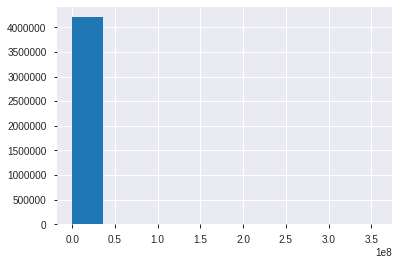

In [34]:
plt.hist(dest_no_merchants['newbalanceDest'])

### Zooming in on zeros

In [35]:
len(dest_no_merchants[dest_no_merchants['newbalanceDest'] == 0])

287938

In [36]:
zeros = dest_no_merchants[dest_no_merchants['newbalanceDest'] == 0]
zeros.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.0,0.0,0,0
22,1,DEBIT,1065.41,C1959239586,1817.00,751.59,C515132998,10330.0,0.0,0,0
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.00,C2001112025,25742.0,0.0,0,0


We have no idea how this is possible...

### Excluding merchants and other zeros

In [37]:
non_zeros = dest_no_merchants[dest_no_merchants['newbalanceDest'] > 0]
non_zeros.shape

(3923187, 11)

(array([3.915489e+06, 5.711000e+03, 1.118000e+03, 4.770000e+02,
        2.190000e+02, 7.700000e+01, 3.700000e+01, 3.000000e+01,
        1.500000e+01, 1.400000e+01]),
 array([1.00000000e-02, 3.56179279e+07, 7.12358558e+07, 1.06853784e+08,
        1.42471712e+08, 1.78089639e+08, 2.13707567e+08, 2.49325495e+08,
        2.84943423e+08, 3.20561351e+08, 3.56179279e+08]),
 <a list of 10 Patch objects>)

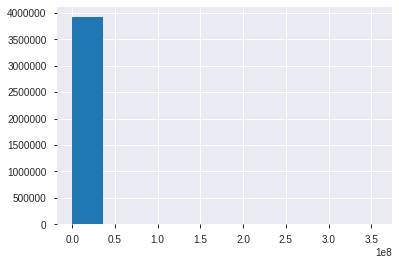

In [38]:
plt.hist(non_zeros['newbalanceDest'])

(array([66384., 68383., 69343., 70478., 70550., 70605., 70860., 69650.,
        69080., 67438.]),
 array([1.00000000e-02, 1.99999660e+04, 3.99999220e+04, 5.99998780e+04,
        7.99998340e+04, 9.99997900e+04, 1.19999746e+05, 1.39999702e+05,
        1.59999658e+05, 1.79999614e+05, 1.99999570e+05]),
 <a list of 10 Patch objects>)

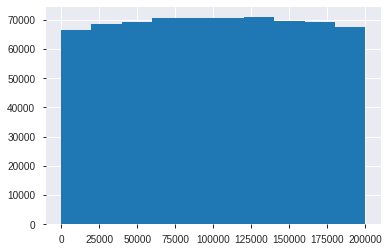

In [39]:
small_new_dest = non_zeros[non_zeros['newbalanceDest'] < 200000]
plt.hist(small_new_dest['newbalanceDest'])

(array([692771., 578314., 410339., 301808., 237622., 191151., 157905.,
        133086., 112130.,  96634.]),
 array([1.00000000e-02, 1.99999987e+05, 3.99999964e+05, 5.99999941e+05,
        7.99999918e+05, 9.99999895e+05, 1.19999987e+06, 1.39999985e+06,
        1.59999983e+06, 1.79999980e+06, 1.99999978e+06]),
 <a list of 10 Patch objects>)

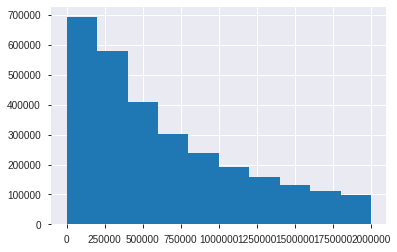

In [40]:
small_new_dest = non_zeros[non_zeros['newbalanceDest'] < 2000000]
plt.hist(small_new_dest['newbalanceDest'])

## isFlaggedFraud

In [14]:
cm = metrics.confusion_matrix(dataset['isFraud'], dataset['isFlaggedFraud'])
print(cm)

[[6354407       0]
 [   8197      16]]


## Resume

We are working on a dataset of over 6 million financial transactions with each one containing 11 attributes. The dataset itself is very unbalanced with only a mere 0,129 % of the transactions being fraudulous. However, said distribution is very realistic.

We observe that only transactions of type cash_out and transfer contain fraud cases. Furthermore, the EDA reveals a clear correlation between the amount transferred and the original amount on the account up until 1,000,000 of amount. It seems that in a lot of cases the criminals transfer all of the money in one time to another account unless when there is more than 1,000,000 available funds which is - presumably - the max transferable amount. 

Studying the destination account, we see that from the 8213 fraudulous operations, 5496 involve a transfer to an account that received other (non fraudulous) transfers in the past. Although, 65% of the fraudulent transactations are destined to an empty account, compared to a 42% of normal operations.

# 3. Traditional machine learning 

## Train test and preprocessing

In [6]:
dataset = dataset.sample(60000)

In [7]:
def transaction_type(t_type):
    if t_type == 'CASH_OUT':
        return 1
    elif t_type == 'TRANSFER':
        return 2
    else:
        return 0

In [8]:
dataset['type'] = dataset.apply(lambda x: transaction_type(x['type']), axis=1)

In [9]:
def is_merchant(account):
    if account.str.contains("M") == True:
        return 1
    else:
        return 0

In [10]:
dataset['nameOrig'] = dataset.apply(lambda x: transaction_type(x['nameOrig']), axis=1)
dataset['nameDest'] = dataset.apply(lambda x: transaction_type(x['nameDest']), axis=1)

In [11]:
dataset.to_csv('clean_fraud_dataset.csv')

In [12]:
Y = dataset["isFraud"]
X = dataset.drop(["isFraud", "isFlaggedFraud"], axis = 1)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# In deep learning we would use a smaller test size, but here for computation reasons we work with a 
# smaller training set and an overly large test set

In [14]:
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

## Logistic regression

In [15]:
logisticRegr = LogisticRegression(solver = 'saga', multi_class = 'ovr', class_weight = 'balanced')

In [16]:
logisticRegr.fit(X_train, Y_train)

/home/manu/.pyenv/versions/3.7.4/envs/jupenv370/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### Train

In [17]:
train_predictions = logisticRegr.predict(X_train)

In [18]:
score = logisticRegr.score(X_train, Y_train)
cm = metrics.confusion_matrix(Y_train, train_predictions)
precision = cm[1][1] / (cm[1][1] + cm[0][1]) * 100
recall = cm[1][1] / (cm[1][1] + cm[1][0]) * 100

In [19]:
print('For the training set, the logistic regression model gives us a ' + str(score * 100) + ' % accuracy, a ' + str(precision) + ' % precision and a ' + str(recall) + ' % recall.')

For the training set, the logistic regression model gives us a 92.22291666666666 % accuracy, a 1.4285714285714286 % precision and a 88.52459016393442 % recall.


### Test

In [20]:
predictions = logisticRegr.predict(X_test)

In [21]:
score = logisticRegr.score(X_test, Y_test)
print(score)

0.9235


In [22]:
cm = metrics.confusion_matrix(Y_test, predictions)
print(cm)

[[11065   916]
 [    2    17]]


[[11065   916]
 [    2    17]]


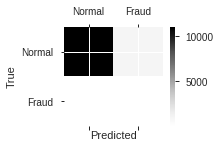

In [23]:
labels = ['Normal', 'Fraud']
cm = metrics.confusion_matrix(Y_test, predictions)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(222)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
precision = cm[1][1] / (cm[1][1] + cm[0][1]) * 100
recall = cm[1][1] / (cm[1][1] + cm[1][0]) * 100

In [25]:
print('Our logistic regression model gives us a ' + str(score * 100) + ' % accuracy, a ' + str(precision) + ' % precision and a ' + str(recall) + ' % recall.')

Our logistic regression model gives us a 92.35 % accuracy, a 1.822079314040729 % precision and a 89.47368421052632 % recall.


## Decision Tree Classifier

In [26]:
clf = DecisionTreeClassifier(random_state = 42, 
                             max_depth = None, 
                             min_samples_split = 7500, 
                             min_samples_leaf = 1500, 
                             class_weight = 'balanced', 
                             max_leaf_nodes = 30)
clf = clf.fit(X_train, Y_train)

### Train

In [27]:
train_predictions = clf.predict(X_train)

In [28]:
score = clf.score(X_train, Y_train)
cm = metrics.confusion_matrix(Y_train, train_predictions)

In [29]:
print('For the training set, the logistic regression model gives us a ' + str(score * 100) + ' % accuracy, a ' + str(precision) + ' % precision and a ' + str(recall) + ' % recall.')

For the training set, the logistic regression model gives us a 85.25833333333334 % accuracy, a 1.822079314040729 % precision and a 89.47368421052632 % recall.


### Test

In [30]:
predictions_tree = clf.predict(X_test)

In [31]:
score = clf.score(X_test, Y_test)
print(score)

0.836


In [32]:
cm = metrics.confusion_matrix(Y_test, predictions_tree)
print(cm)

[[10014  1967]
 [    1    18]]


[[10014  1967]
 [    1    18]]


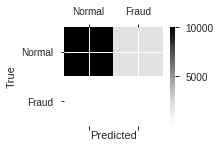

In [33]:
labels = ['Normal', 'Fraud']
cm = metrics.confusion_matrix(Y_test, predictions_tree)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(222)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

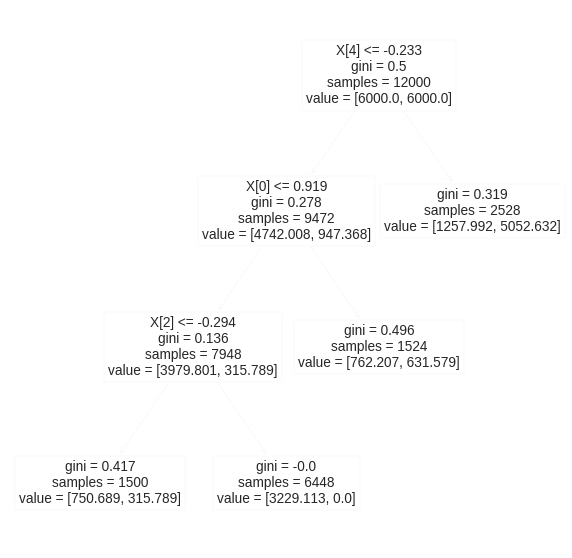

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(clf.fit(X_test, Y_test), ax=ax) 
plt.show()

In [35]:
precision = cm[1][1] / (cm[1][1] + cm[0][1]) * 100
recall = cm[1][1] / (cm[1][1] + cm[1][0]) * 100

In [36]:
print('Our logistic regression model gives us a ' + str(score * 100) + ' % accuracy, a ' + str(precision) + ' % precision and a ' + str(recall) + ' % recall.')

Our logistic regression model gives us a 83.6 % accuracy, a 0.906801007556675 % precision and a 94.73684210526315 % recall.


## Random forest classifier

In [37]:
rfc = RandomForestClassifier(n_estimators=100,
                             max_depth = None, 
                             min_samples_split = 7500, 
                             min_samples_leaf = 1500, 
                             class_weight = 'balanced', 
                             max_leaf_nodes = 30)

rfc = rfc.fit(X_train, Y_train)

### Train

In [38]:
train_predictions = rfc.predict(X_train)

In [39]:
score = rfc.score(X_train, Y_train)
cm = metrics.confusion_matrix(Y_train, train_predictions)
precision = cm[1][1] / (cm[1][1] + cm[0][1]) * 100
recall = cm[1][1] / (cm[1][1] + cm[1][0]) * 100

In [40]:
print('For the training set, the logistic regression model gives us a ' + str(score * 100) + ' % accuracy, a ' + str(precision) + ' % precision and a ' + str(recall) + ' % recall.')

For the training set, the logistic regression model gives us a 92.925 % accuracy, a 1.7366136034732274 % precision and a 98.36065573770492 % recall.


### Test

In [41]:
predictions = rfc.predict(X_test)

In [42]:
score = rfc.score(X_test, Y_test)
print(score)

0.9389166666666666


In [43]:
cm = metrics.confusion_matrix(Y_test, predictions)
print(cm)

[[11250   731]
 [    2    17]]


[[11250   731]
 [    2    17]]


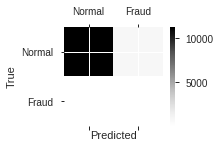

In [44]:
labels = ['Normal', 'Fraud']
cm = metrics.confusion_matrix(Y_test, predictions)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(222)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [45]:
precision = cm[1][1] / (cm[1][1] + cm[0][1]) * 100
recall = cm[1][1] / (cm[1][1] + cm[1][0]) * 100

In [46]:
print('Our logistic regression model gives us a ' + str(score * 100) + ' % accuracy, a ' + str(precision) + ' % precision and a ' + str(recall) + ' % recall.')

Our logistic regression model gives us a 93.89166666666667 % accuracy, a 2.272727272727273 % precision and a 89.47368421052632 % recall.
